# Google Colab - Numba CPU

## Abordagem PAD no ambiente Python para um caso de teste de computação científica

Exemplo mostrando abordagen de Processamento de Alto Desempenho (PAD ou HPC) no ambiente Python, para a solução de um caso de teste de computação científica, usando o Google Colab (GC). Para este exemplo foi selecionado o compilador Numba.

## Caso de teste: estêncil de cinco pontos

(versão sequencial)

O caso de teste adotado é um conhecido problema de transferência de calor sobre uma superfície finita, modelado pela equação diferencial parcial de Poisson, que modela a distribuição de temperatura normalizada sobre a superfície ao longo de uma série de iterações que compõem a simulação. A equação de Poisson discretizada 2D com um estêncil de 5 pontos pode ser expressa por:

$$
\frac{\partial^2 U}{\partial x^2} +
\frac{\partial^2 U}{\partial y^2} \approx
\frac{U_{i+1,j}+U_{i,j+1}-4U_{i,j}+U_{i-1,j}+U_{i,j-1}}{h^2}
$$

Comumente empregada para soluções numéricas, esta equação é discretizada em uma grade finita e resolvida por um método de diferenças finitas. O algoritmo específico requer o cálculo de um estêncil de 5 pontos sobre a grade de domínio 2D para atualizar as temperaturas a cada etapa de tempo. Para este problema, são assumidos um campo de temperatura uniforme inicial com valor zero sobre a superfície, e condições adiabáticas ou de contorno de Dirichlet. O estêncil de 5 pontos consiste em atualizar um ponto da grade fazendo a média das temperaturas de si mesmo com as temperaturas de seus quatro vizinhos, esquerda-direita e cima-baixo na grade. O campo de temperatura $ U $ é definido sobre uma grade discreta $ (x, y) $ com resoluções espaciais $ \Delta x = \Delta y = h $. Assim, a discretização mapeia as coordenadas cartesianas reais $ (x, y) $ para uma grade discreta $ (i, j) $, com $ U_ {x, y} = U_ {i, j} \,, \, U_ {x + h, y} = U_ {i + 1, j} \, $ para a dimensão $ x $, e analogamente para a dimensão $ y $. A grade é representada pela figura:

![](http://drive.google.com/uc?id=1MYgCRB1iENh94vhCJpsnCpLg28BT4LKO)

Três fontes de calor de taxa constante foram colocadas em pontos de grade localizados, e cada uma introduz uma quantidade de calor unitária a cada passo de tempo. A simulação de transferência de calor é modelada por um número finito de etapas de tempo, sendo todos os pontos da grade atualizados a cada etapa. A distribuição da temperatura será determinada pelas fontes de calor e pelas condições de contorno de Dirichlet, o que implica em temperatura zero nos pontos de fronteira da grade. O resultado final é representado pela figura:

![](http://drive.google.com/uc?id=1DppDwgyRZGx7f7xYU_db5CqJiFGudTMk)

---

# Implementação

A parte computacionalmente intensiva é a atualização dos pontos da grade (atualização da matriz) utilizando a equação (cálculo do estêncil), onde dois laços de repetição são utilizados, um para cada dimensão.

Em cada iteração, após a atualização da grade uma unidade de calor é inserida em três pontos de inserção de calor.

Duas matrizes são utilizadas alternadamente nas iterações pois o cálculo do estêncil depende de pontos de células vizinhas que não podem ser sobrepostos. Desta forma, uma "nova" matriz de resultados é utilizada para armazenar os cálculos feitos a partir da matriz "antiga" que contém os dados. Quando a matriz "nova" está finalizada, a matriz "antiga" pode então ser descartada e utilizada para armazenar os resultados da próxima iteração, e desta forma as duas matrizes ficam alternando suas funções durante as iterações.

Ao término das iterações, é feita uma soma de todos os pontos da grade, para obter o total de calor.

---

## Recursos disponíveis no GC

O GC disponibiliza um único núcleo físico de CPU, e um núcleo lógio usando o hyperthreading do processador Intel. Desta forma ao utilizar paralelismo o ganho de desempenho é pequeno. Porém as instruções avx2 (vetorização) estão disponíveis e são a melhor opção para aumento de desempenho na CPU:

In [1]:
! lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs 

Intel Turbo Boost aparentemente não está ativo:

In [2]:
! cat /sys/devices/system/cpu/intel_pstate/no_turbo

cat: /sys/devices/system/cpu/intel_pstate/no_turbo: No such file or directory


Hyperthreading, ativo = 1 :

In [3]:
! cat /sys/devices/system/cpu/smt/active

1


In [4]:
! df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          74G   44G   30G  60% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
tmpfs           6.4G   28K  6.4G   1% /var/colab
/dev/sda1        81G   48G   33G  60% /opt/bin/.nvidia
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  1.3G   14G   9% /content/drive


In [5]:
! free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        1.0G        8.8G        1.2M        2.8G         11G
Swap:            0B          0B          0B


As GPUs disponíveis (aleatoriamente) são: Nvidia K80 (mais comum), T4, P4, e P100. Nem sempre a GPU está disponível, depende dos limites da versão free do GC.

In [6]:
! nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-1046025b-c8e2-ee6e-d208-e6a2568204f6)


In [7]:
! lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic


---

## Fortran 90 sequencial

O código F90 pode ser desenvolvindo de várias maneiras, como por exemplo, usando uma [IDE para F90](https://cbfortran.sourceforge.io/), usando um [Kernel para o Jupyter Notebook (JN)](https://gitlab.com/lfortran/fortran_kernel), ou então usando uma célula do JN como um editor de texto comum para criar/gravar um arquivo no disco, como mostrado a seguir:

In [1]:
%%writefile heat_seq.f90

! computationally intensive core
subroutine kernel(anew, aold, sizeStart, sizeEnd)
    double precision, intent(out) :: anew(:,:)
    double precision, intent(in)  :: aold(:,:)
    integer, intent(in) :: sizeStart, sizeEnd
    integer             :: i, j

    do j = sizeStart, sizeEnd
        do i = sizeStart, sizeEnd
            anew(i,j)= aold(i,j)/2.0  &
                +(aold(i-1,j)+aold(i+1,j)+aold(i,j-1)+aold(i,j+1))/8.0
        enddo
    enddo   
end subroutine

! main routine
program stencil
    implicit none
    interface
        subroutine kernel(anew, aold, sizeStart, sizeEnd)
            double precision, intent(out) :: anew(:,:)
            double precision, intent(in)  :: aold(:,:)
            integer, intent(in) :: sizeStart, sizeEnd
        end subroutine
    end interface
    
    ! parameters for calculation
    integer             :: n=2400     ! n x n grid
    integer             :: energy=1   ! energy to be injected per iteration
    integer             :: niters=250 ! number of iterations

    ! other variables
    integer, parameter  :: nsources=3
    integer, dimension(3, 2)        :: sources
    double precision, allocatable   :: aold(:,:), anew(:,:)
    integer             :: iters, i, j, size, sizeStart, sizeEnd
    double precision    :: heat=0.0           
    
    size = n + 2
    sizeStart = 2
    sizeEnd = n + 1

    allocate(aold(size, size))
    allocate(anew(size, size))
    aold = 0.0
    anew = 0.0

    sources(1,:) = (/ n/2,   n/2   /)
    sources(2,:) = (/ n/3,   n/3   /)
    sources(3,:) = (/ n*4/5, n*8/9 /)

    do iters = 1, niters, 2
        
        ! odd iteration: anew <- stencil(aold)
            
        ! computationally intensive core
        call kernel(anew, aold, sizeStart, sizeEnd)
        
        ! three-point energy insertion
        do i = 1, nsources
            anew(sources(i,1)+1, sources(i,2)+1) =  &
                anew(sources(i,1)+1, sources(i,2)+1) + energy
        enddo

        ! even iteration: aold <- stencil(anew)
           
        ! computationally intensive core
        call kernel(aold, anew, sizeStart, sizeEnd)

        ! three-point energy insertion       
        do i = 1, nsources
            aold(sources(i,1)+1, sources(i,2)+1) =  &
                aold(sources(i,1)+1, sources(i,2)+1) + energy
        enddo

    enddo

    ! sum of grid points to get total heat
    heat = 0.0
    do j = sizeStart, sizeEnd
        do i = sizeStart, sizeEnd
            heat = heat + aold(i,j)
        end do
    end do

    ! show de result
    write(*, "('Heat: ' f0.4)") heat

    deallocate(aold)
    deallocate(anew)

end

Writing heat_seq.f90


Na célula a seguir, o ponto de exclamação significa que o comando será executado em uma sessão do shell do sitema operacional:

In [2]:
! gfortran --version

GNU Fortran (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



SD:

    GNU Fortran (GCC) 4.8.5 20150623 (Red Hat 4.8.5-36)
    Copyright (C) 2015 Free Software Foundation, Inc.

Compilando usando a flag de otimização `-O3`:

In [3]:
! time gfortran  -O3  -o heat_seq  heat_seq.f90


real	0m0.624s
user	0m0.093s
sys	0m0.037s


Execução do programa:

In [4]:
! time ./heat_seq

Heat: 750.0000

real	0m3.127s
user	0m3.046s
sys	0m0.053s


SD:

    Heat: 750.0000

    real	0m3.121s
    user	0m2.965s
    sys	0m0.082s

# Python sequencial (sem Numba)

Versão do Python utilizado:

In [5]:
! python --version

Python 3.7.12


SD:

    Python 3.8.5

`numpy` é a principal biblioteca para computação científica:

In [6]:
import numpy as np

Os principais parâmetros são:

* `n`: o tamanho da grade (n x n)
* `energy`: a unidade de energia a ser inserida em três pontos em cada iteração
* `niters`: a quantidade de iterações

In [7]:
n      = 2400
energy = 1.0
niters = 250

Outras variáveis e arrays utilidados:
* `anew` e `aold`: matrizes (arrays) para armazenar a grade, e também a zona de fronteira da grade
* `sources`: três pontos de inserção de energia

In [9]:
anew         = np.zeros((n + 2,  n + 2), np.float64)
aold         = np.zeros((n + 2,  n + 2), np.float64)
sources      = np.empty((3, 2), np.int16)    # sources of energy
sources[:,:] = [ [n//2, n//2], [n//3, n//3], [n*4//5, n*8//9] ]

Neste exemplo, para a implementação da equação foram utilizados algoritmos disponíveis na literatura, como os descritos por [Zhu et al.](https://ieeexplore.ieee.org/document/7152597) e [Balaji](https://www.mcs.anl.gov/~thakur/sc17-mpi-tutorial/):

$\mathbf{for} \ \ i \ \leftarrow \ 1 \ \ \mathbf{to} \ \ (matrix \ size \ x) \ \ \mathbf{do}$

$\quad \mathbf{for} \ \ j \ \leftarrow \ 1 \ \ \mathbf{to} \ \ (matrix \ size \ y) \ \ \mathbf{do}$

$\qquad anew[i,j]= \frac{aold[i,j]}{2.0}+\frac{aold[i-1,j]+aold[i+1,j]+aold[i,j-1]+aold[i,j+1]}{8.0}$

Na célula a seguir é possível visualizar a equação e os laços de repetição que atualizam a grade. O laços estão embutidos na sintaxe `:` (dois pontos) dos índices da matriz 
(array numpy). Índices negativos significam o final da matriz. A matriz `aold` contém os dados, e a matriz `anew` armazena os resultados dos cálculos. É o trecho de código de computação intensiva, e o fato de ter sido colocado em uma função será útil nos próximos exemplos:

In [10]:
def kernel(anew, aold) :
    anew[1:-1,1:-1] = (aold[1:-1,1:-1]/2.0
        +(aold[2:,1:-1]+aold[:-2,1:-1]+aold[1:-1,2:]+aold[1:-1,:-2])/8.0)

A cada passo do laço de repetição principal, são realizas duas chamadas à função `kernel` para atualizar a grade, desta forma reduzindo pela metade a quantidade de repetições necessárias no laço. A linha de código

```python
anew[sources[:, 0], sources[:, 1]] += energy
```

utiliza a sintaxe "`:` (dois pontos) nos índices dos arrays para indicar laço de repetição embutido, que é usado para inserir (somar) os três pontos de energia na grade. `t2` e `t3` são usados para medir o tempo de execução. `anew` e `aold` são as matrizes que ficam alternando nas funções de armazenar o resultado, e de manter os dados durante o cálculo do estêncil. `%%timeit` é um comando o JN que mede o tempo de execução, neste caso executando uma vez a célula (`-r1`), e a cada vez que a célula é executada realiza um laço de repetição (`-n1`):

In [11]:
%%timeit -r1 -n1
for _ in range(0, niters, 2):
    kernel(anew, aold)
    anew[sources[:, 0], sources[:, 1]] += energy
    kernel(aold, anew)
    aold[sources[:, 0], sources[:, 1]] += energy

1 loop, best of 1: 21.4 s per loop


SD:

    33.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Após as iterações, é feita a soma das energias em cada ponto da grade (soma de todos os elementos da matriz), para obter o total de calor:

In [12]:
f"Heat: {np.sum(aold[1:-1, 1:-1]):.4f}"

'Heat: 750.0000'

`%%prun` usa o Python profiler e mostra os tempos com mais detalhes:

In [12]:
%%prun -l 5 -s cumulative
for _ in range(0, niters, 2):
    kernel(anew, aold)
    anew[sources[:, 0], sources[:, 1]] += energy
    kernel(aold, anew)
    aold[sources[:, 0], sources[:, 1]] += energy

         253 function calls in 20.605 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   20.605   20.605 {built-in method builtins.exec}
        1    0.016    0.016   20.605   20.605 <string>:2(<module>)
      250   20.588    0.082   20.588    0.082 <ipython-input-9-c8dd1f9fd6f9>:1(kernel)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

SD:

    253 function calls in 35.546 seconds

      Ordered by: cumulative time

      ncalls  tottime  percall  cumtime  percall filename:lineno(function)
            1    0.000    0.000   35.546   35.546 {built-in method builtins.exec}
            1    0.020    0.020   35.546   35.546 <string>:1(<module>)
          250   35.526    0.142   35.526    0.142 <ipython-input-27-c8dd1f9fd6f9>:1(kernel)
            1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

---

Fazendo um teste com `n = 8`, apenas para visualizar a grade final:

In [13]:
n            = 8
anew         = np.zeros((n + 2,  n + 2), np.float64)
aold         = np.zeros((n + 2,  n + 2), np.float64)
sources      = np.empty((3, 2), np.int16)    # sources of energy
sources[:,:] = [ [n//2, n//2], [n//3, n//3], [n*4//5, n*8//9] ]
for _ in range(0, niters, 2):
    kernel(anew, aold)
    anew[sources[:, 0], sources[:, 1]] += energy
    kernel(aold, anew)
    aold[sources[:, 0], sources[:, 1]] += energy

In [14]:
np.set_printoptions(precision=1, floatmode='fixed')
aold

array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.8, 1.5, 1.3, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0],
       [0.0, 1.5, 4.0, 2.6, 2.1, 1.6, 1.2, 0.8, 0.4, 0.0],
       [0.0, 1.3, 2.5, 2.8, 3.1, 2.4, 1.8, 1.2, 0.6, 0.0],
       [0.0, 1.0, 2.1, 3.1, 5.1, 3.1, 2.3, 1.7, 0.9, 0.0],
       [0.0, 0.8, 1.6, 2.3, 3.1, 2.7, 2.5, 2.4, 1.2, 0.0],
       [0.0, 0.6, 1.1, 1.6, 2.1, 2.2, 2.6, 4.1, 1.6, 0.0],
       [0.0, 0.4, 0.7, 1.0, 1.3, 1.5, 1.7, 1.9, 1.0, 0.0],
       [0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.8, 0.4, 0.0],
       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

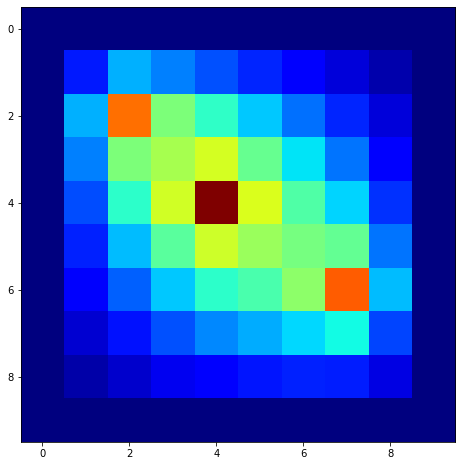

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(aold, cmap='jet')

---

# Numba sequencial (1 thread)

Numba reconhece apenas um subconjunto de Python e Numpy. É usado geralmente apenas nos trechos que exigem intensidade computacional, e o resto do código é executado de forma interpretada por Python padrão. Para o exemplo a seguir, adicionamos medição de tempo e também um decorador na função `kernel` para que Numba a compile em tempo de execução, JIT.

Com relação ao código anterior, a biblioteca `numba` (compilador Numba) é adicionada neste trecho:

In [22]:
import numpy as np
from numba import njit, set_num_threads, get_num_threads, threading_layer, config

Este trecho é o mesmo do exemplo anterior:

In [23]:
# parameters
n            = 2400    # n x n grid
energy       = 1.0     # energy to be injected per iteration
niters       = 250     # number of iterations
# initialize the data arrays
anew         = np.zeros((n + 2,  n + 2), np.float64)
aold         = np.zeros((n + 2,  n + 2), np.float64)
# initialize three heat sources
sources      = np.empty((3, 2), np.int16)    # sources of energy
sources[:,:] = [ [n//2, n//2], [n//3, n//3], [n*4//5, n*8//9] ]

A função `kernel`recebe um decorador para indicar para Numba que a função deve ser compilada em tempo de execução, JIT. `float64` são os tipos dos parâmetros, `fastmat` aumenta a velocidade dos cálculos em detrimento da precisão, `parallel` indica a utilização de otimizações como vetorização, e `nogil` desliga o GIL (*global interpreter lock*). `THREADING_LAYER` configura o uso da biblioteca OpenMP:

In [24]:
# set the threading layer before any parallel target compilation
config.THREADING_LAYER = 'omp'    # OpenMP

# computationally intensive core
@njit('(float64[:,:],float64[:,:])', parallel=True, fastmath=True, nogil=True)
def kernel(anew, aold) :
    anew[1:-1,1:-1] = (aold[1:-1,1:-1]/2.0
        +(aold[2:,1:-1]+aold[:-2,1:-1]+aold[1:-1,2:]+aold[1:-1,:-2])/8.0)

`t0`, `t1`, etc., são usados para medição de tempo, `threading_layer` mostra qual biblioteca está sendo usada (OpenMP, Intel TBB, ou biblioteca própria), e `get_num_threads` mostra quantos threads estão sendo usados na execução: se > 1 significa que estão sendo utilizados os recursos de processamento paralelo usando threads:

In [25]:
%%prun -l 5 -s cumulative
# main routine
set_num_threads(1)       # set the number of threads
for _ in range(0, niters, 2) :
    kernel(anew, aold)
    anew[sources[:, 0], sources[:, 1]] += energy
    kernel(aold, anew)
    aold[sources[:, 0], sources[:, 1]] += energy
heat = np.sum(aold)      # system total heat

         469 function calls (451 primitive calls) in 3.077 seconds

   Ordered by: cumulative time
   List reduced from 69 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    3.077    3.077 {built-in method builtins.exec}
        1    0.022    0.022    3.077    3.077 <string>:3(<module>)
      250    3.050    0.012    3.050    0.012 <ipython-input-24-dd9b4388221b>:5(kernel)
        1    0.000    0.000    0.004    0.004 <__array_function__ internals>:2(sum)
        1    0.000    0.000    0.004    0.004 {built-in method numpy.core._multiarray_umath.implement_array_function}

SD:

            253 function calls in 18.361 seconds

      Ordered by: cumulative time

      ncalls  tottime  percall  cumtime  percall filename:lineno(function)
            1    0.000    0.000   18.361   18.361 {built-in method builtins.exec}
            1    0.015    0.015   18.361   18.361 <string>:2(<module>)
          250   18.346    0.073   18.346    0.073 <ipython-input-20-c8dd1f9fd6f9>:1(kernel)
            1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

In [26]:
# show the result
print(f"Heat: {heat:.4f}", end=" | ")
print(f"Threading layer: {threading_layer()}", end=" | ")
print(f"Thread count: {get_num_threads()}")

Heat: 750.0000 | Threading layer: omp | Thread count: 1


## Criando uma função para comparar 1 e 2 threads

In [19]:
def heat(tr) :
    import numpy as np
    from numba import njit, set_num_threads, get_num_threads, threading_layer, config

    # parameters
    n            = 2400    # n x n grid  <-- function parameter
    energy       = 1.0     # energy to be injected per iteration
    niters       = 250     # number of iterations
    # initialize the data arrays
    anew         = np.zeros((n + 2,  n + 2), np.float64)
    aold         = np.zeros((n + 2,  n + 2), np.float64)
    # initialize three heat sources
    sources      = np.empty((3, 2), np.int16)    # sources of energy
    sources[:,:] = [ [n//2, n//2], [n//3, n//3], [n*4//5, n*8//9] ]

    # set the threading layer before any parallel target compilation
    config.THREADING_LAYER = 'omp'    # OpenMP

    # computationally intensive core
    @njit('(float64[:,:],float64[:,:])', parallel=True, fastmath=True, nogil=True)
    def kernel(anew, aold) :
        anew[1:-1,1:-1] = (aold[1:-1,1:-1]/2.0
            +(aold[2:,1:-1]+aold[:-2,1:-1]+aold[1:-1,2:]+aold[1:-1,:-2])/8.0)

    # main routine
    set_num_threads(tr)       # set the number of threads
    for _ in range(0, niters, 2) :
        kernel(anew, aold)
        anew[sources[:, 0], sources[:, 1]] += energy
        kernel(aold, anew)
        aold[sources[:, 0], sources[:, 1]] += energy
    heat = np.sum(aold)    # system total heat
    

    # show the result
    print(f"Heat: {heat:.4f}", end=" | ")
    print(f"Threading layer: {threading_layer()}", end=" | ")
    print(f"Thread count: {get_num_threads()}")

In [28]:
%%timeit -n1 -r1
heat(1)

Heat: 750.0000 | Threading layer: omp | Thread count: 1
1 loop, best of 1: 4.15 s per loop


## 2 threads

> Notas:
> * com 1 núcleo físico e 1 lógico (*hyperthreading*) ligado, o aumento de velocidade não é grande
> * a execução usando threads (OpenMP, etc.) geralmente é feita em um nó. Para utilizar vários nós de computação, geralmente usa-se a biblioteca de troca de mensagens (MPI) que utiliza processos ao invés de threads. Também é possível combinar OpenMP e MPI, embora torne o código mais complexo
> * Threads utiliza o modelo de memória compartilhada, e processos utiliza o modelo de memória com espaços de endereçamento separados

In [29]:
%%timeit -n1 -r1
heat(2)

Heat: 750.0000 | Threading layer: omp | Thread count: 2
1 loop, best of 1: 3.81 s per loop
